# Project: Predict Bike Sharing Demand with AutoGluon


## Download the Kaggle dataset using the kaggle python library

### Install packages

In [2]:
!pip install kaggle
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

     |████████████████████████████████| 63 kB 368 kB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 78 kB 1.1 MB/s             
Using legacy 'setup.py install' for kaggle, since package 'wheel' is not installed.
    Running setup.py install for kaggle ... done
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
  Using cached pip-23.1.2-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
  Using cached setuptools-67.8.0-py3-none-any.whl (1.1 MB)
  Using cached wheel-0.40.0-py3-none-any.whl (64 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.3.0
    Uninstalling setuptools-59.3.0:
      Successfully uninstalled setuptools-59.3.0
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
  Using cached bokeh-2.0.1-py3-none-an

### Setup Kaggle API Key

In [3]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "demiladej"
kaggle_key = "#####"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

## Download and explore dataset

In [5]:
!pip install kaggle
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 8.15MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [6]:
import pandas as pd
from autogluon.tabular import TabularPredictor

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv', parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [9]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv', parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [11]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [13]:
display(submission.shape)
display(test.shape)
display(train.shape)

(6493, 2)

(6493, 9)

(10886, 12)

## Train a model using AutoGluon’s Tabular Prediction

Requirements:

- We are prediting count, so it is the label we are setting.
- Ignore casual and registered columns as they are also not present in the test dataset.
- Use the root_mean_squared_error as the metric to use for evaluation.
- Set a time limit of 10 minutes (600 seconds).
- Use the preset best_quality to focus on creating the best model.

In [14]:
predictor = TabularPredictor(label='count', eval_metric='root_mean_squared_error', learner_kwargs={'ignored_columns': ['casual', 'registered']}).fit(
     train_data=train, time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20230604_105035/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230604_105035/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Apr 25 15:24:19 UTC 2023
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fe

### Review AutoGluon's training run with ranking of models that did the best.

In [15]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.102021      14.427037  554.153515                0.001127           0.330167            3       True         14
1   RandomForestMSE_BAG_L2  -53.436214      10.610104  409.770104                0.597236          26.316361            2       True         12
2          LightGBM_BAG_L2  -55.066796      10.371259  408.406126                0.358391          24.952383            2       True         11
3          CatBoost_BAG_L2  -55.893021      10.095843  447.287855                0.082975          63.834113            2       True         13
4        LightGBMXT_BAG_L2  -60.091891      13.387308  438.720491                3.374440          55.266749            2       True         10
5    KNeighborsDist_BAG_L1  -84.125061       0.103768    0.029848         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54

### Create predictions from test dataset

In [16]:
predictions = predictor.predict(test)
predictions.head()

0    23.388235
1    42.028351
2    45.724121
3    48.346741
4    51.363438
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [17]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.673645
std        90.050674
min         3.109513
25%        19.857468
50%        64.210983
75%       167.256699
max       366.519135
Name: count, dtype: float64

In [18]:
# How many negative values do we have?
predictions[predictions<0]

Series([], Name: count, dtype: float32)

In [ ]:
# Set them to zero

#### Yaay! We don't have any zero values!

### Set predictions to submission dataframe, save, and submit

In [19]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [20]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 463kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - My Submissions

In [21]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status   publicScore  privateScore  
--------------  -------------------  --------------------  -------  -----------  ------------  
submission.csv  2023-06-04 11:05:44  first raw submission  pending                             


#### Initial score of ``1.80425``

##### It's in my kaggle submissions!

## Exploratory Data Analysis and Creating an additional feature

- Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>]], dtype=object)

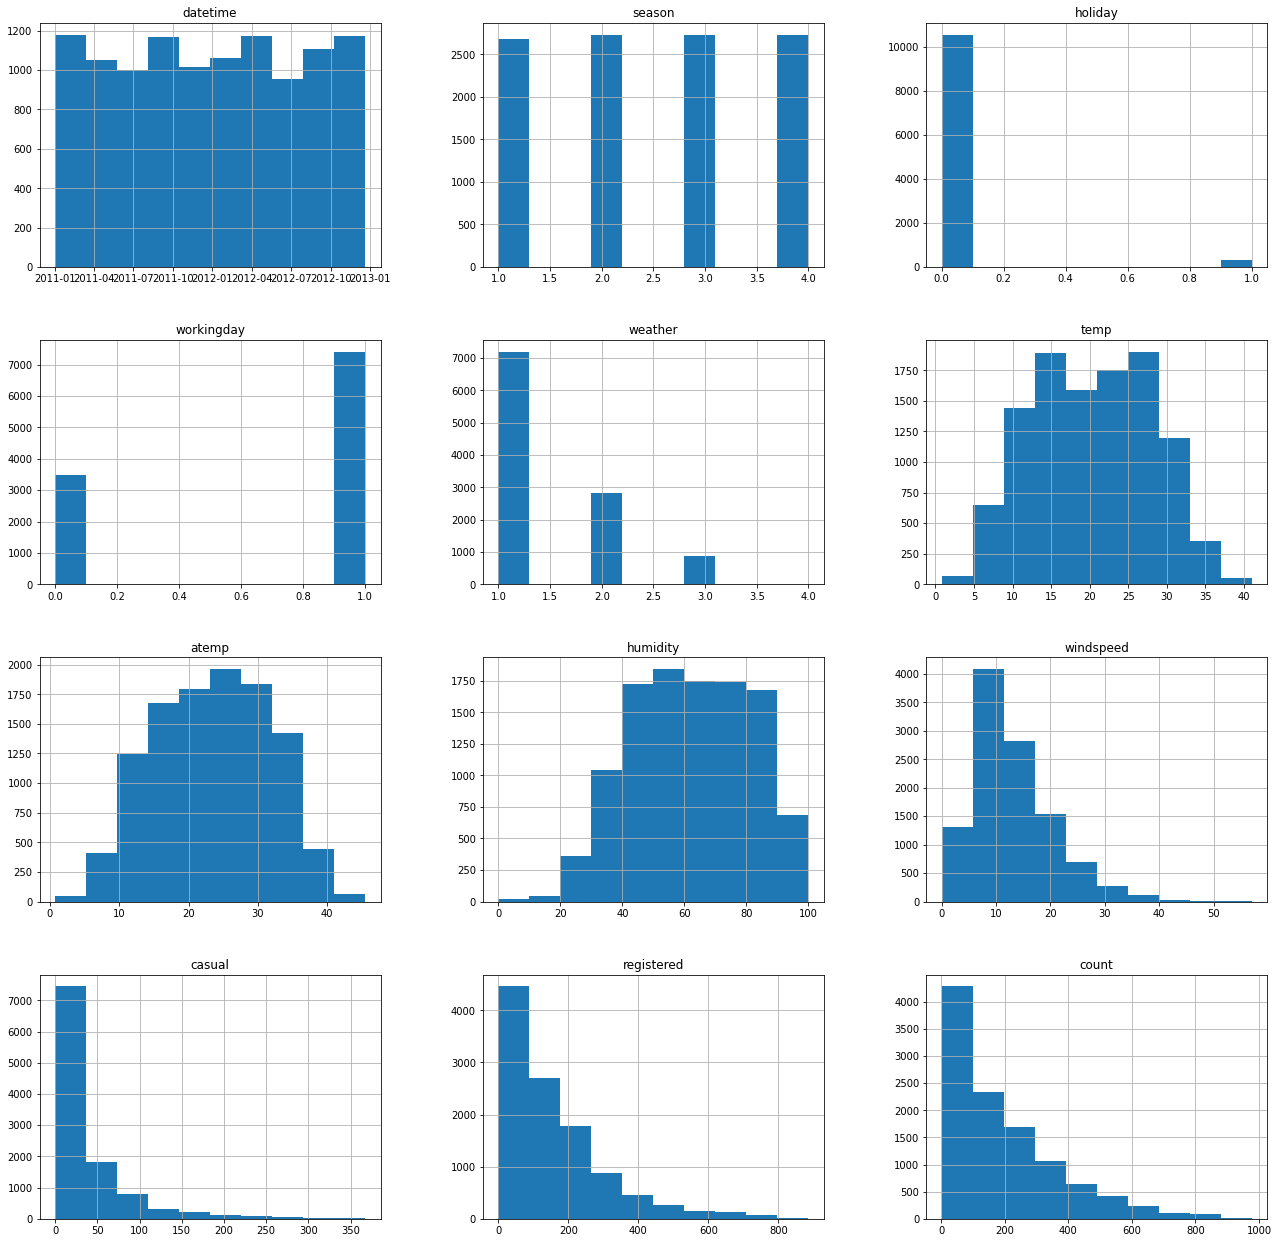

In [24]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(22,22))

In [25]:
# create a new feature
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour

### Make category types for these so models know they are not just numbers

- AutoGluon originally sees these as ints, but in reality they are int representations of a category.
- Setting the dtype to category will classify these as categories in AutoGluon.

In [26]:
train["season"] = train['season'].astype('category')
train["weather"] = train['weather'].astype('category')
test["season"] = test['season'].astype('category')
test["weather"] = test['weather'].astype('category')

In [27]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'casual'}>],
       [<AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'month'}>],
       [<AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'hour'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

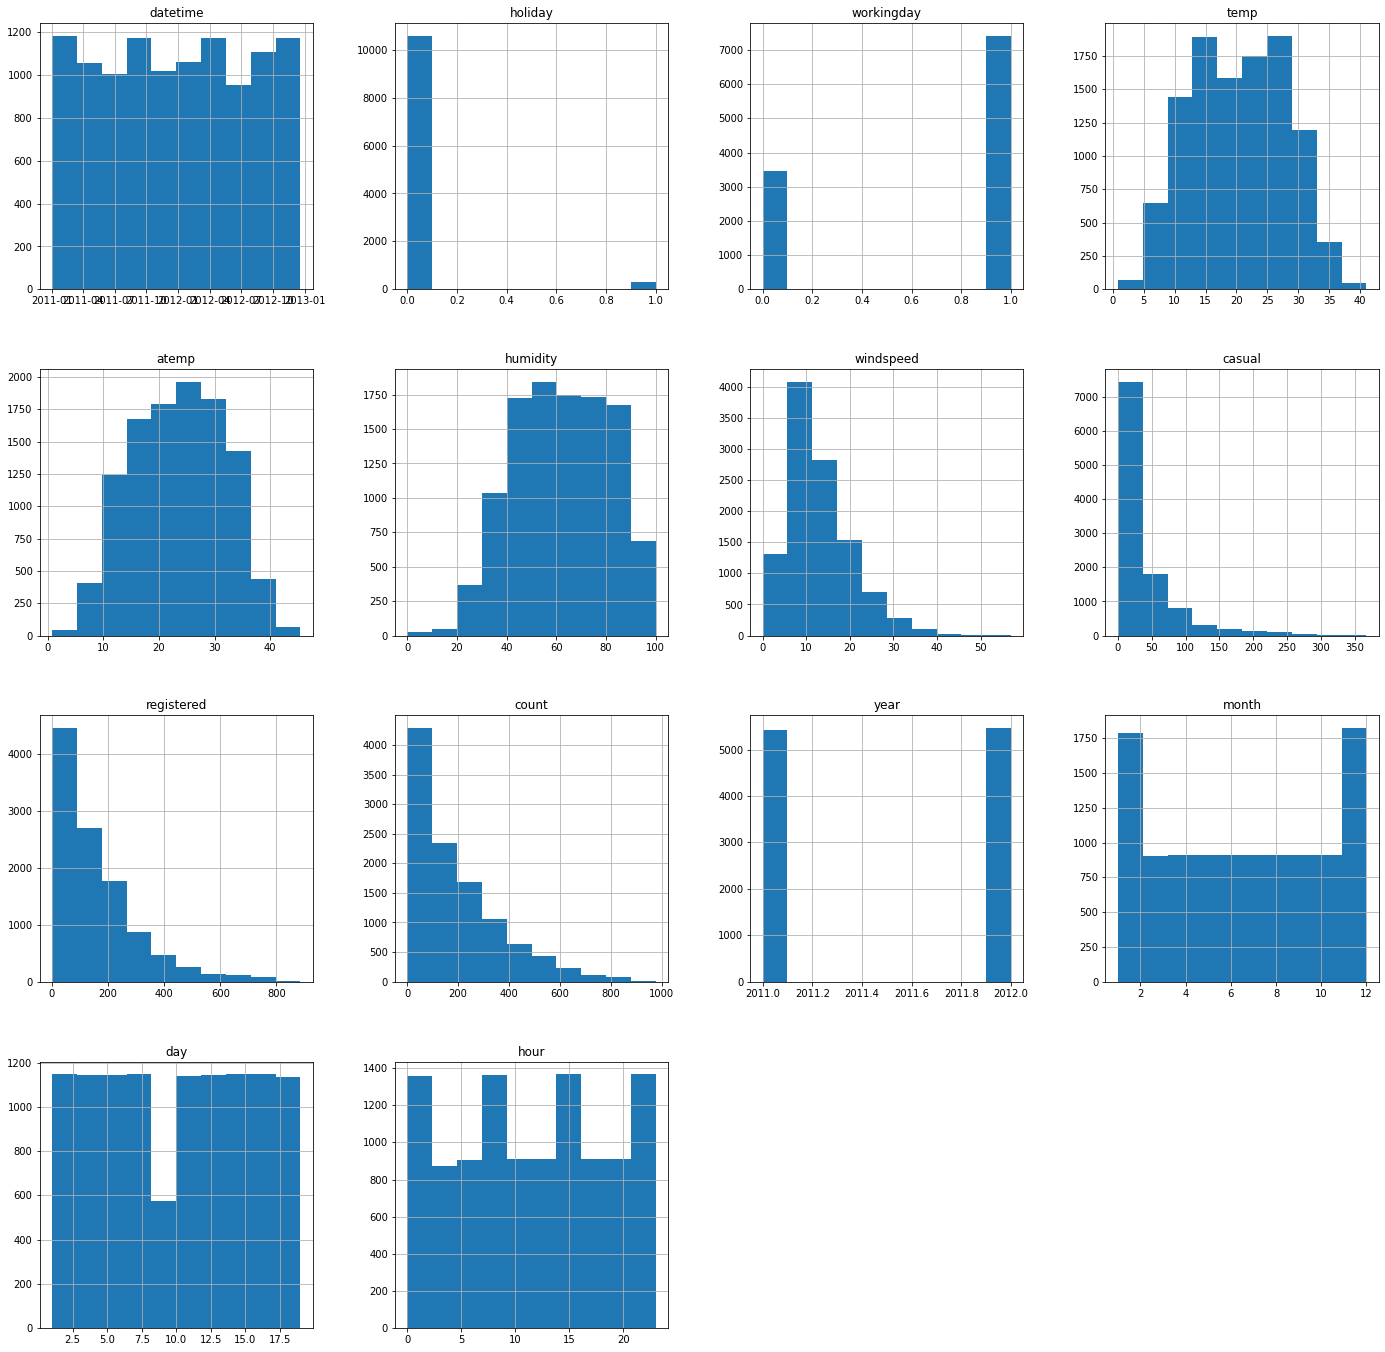

In [29]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(24,24))

## Rerun the model with the same settings as before, just with more features

In [31]:
predictor_new_features = TabularPredictor(label='count', 
                                          problem_type='regression',
                                          eval_metric='root_mean_squared_error',
                                          learner_kwargs={'ignored_columns': ['casual', 'registered']}).fit(
    train_data=train,
    time_limit=600,
    presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20230604_112443/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230604_112443/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Apr 25 15:24:19 UTC 2023
Train Data Rows:    10886
Train Data Columns: 15
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2069.19 MB
	Train Data (Original)  Memory Usage: 0.98 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features

In [32]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.224106      15.913544  559.862832                0.000819           0.441476            3       True         15
1          CatBoost_BAG_L2  -30.518260      13.965574  473.607318                0.106699          71.864403            2       True         13
2          LightGBM_BAG_L2  -30.578185      14.137310  426.008119                0.278434          24.265204            2       True         11
3        LightGBMXT_BAG_L2  -31.175901      14.913351  431.751518                1.054476          30.008602            2       True         10
4     ExtraTreesMSE_BAG_L2  -31.488028      14.464851  411.322592                0.605976           9.579677            2       True         14
5   RandomForestMSE_BAG_L2  -31.568826      14.473117  433.283147         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -34.34599701170154,
  'LightGBM_BAG_L1': -3

In [ ]:
# Remember to set all negative values to zero
new_predictions = predictor_new_features.predict(test)
new_predictions[new_predictions<0] = 0

In [33]:
# Remember to set all negative values to zero
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

0    15.374643
1    11.341370
2    10.246185
3     9.208454
4     8.181679
Name: count, dtype: float32

In [34]:
predictions_new_features.describe()

count    6493.000000
mean      153.213287
std       132.474930
min         2.035467
25%        52.748791
50%       119.593315
75%       215.989227
max       817.359436
Name: count, dtype: float64

In [35]:
predictions_new_features[predictions_new_features<0]

Series([], Name: count, dtype: float32)

We have no negative values!

In [ ]:

# Same submitting predictions
submission_new_features = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission_new_features["count"] = new_predictions
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [38]:
# Same submitting predictions
submission_new_features = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [39]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 329kB/s]
Successfully submitted to Bike Sharing Demand

In [40]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2023-06-04 11:41:11  new features          complete  0.67145      0.67145       
submission.csv               2023-06-04 11:05:44  first raw submission  complete  1.80425      1.80425       


#### New Score of *0.67145*

## Hyper parameter optimization
- There are many options for hyper parameter optimization.
- Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
- The hyperparameters of the models themselves that are in AutoGluon. Those need the hyperparameter and hyperparameter_tune_kwargs arguments.

In [42]:
import autogluon.core as ag
# From documentation
nn_options = {
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1), # dropout probability
}

gbm_options = {
    'num_boost_round': 100, # number of boosting rounds
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36), # number of leaves in trees
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN': nn_options,
                  }

num_trials = 4 # try at most 4 different hyperparameter configuration for each type of model
search_strategy = 'auto' # tune hyperparameters using Bayesian optimization routine with a local scheduler

hyperparameter_tune_kwargs = {
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

predictor_new_hpo = TabularPredictor(
    label='count', problem_type='regression', eval_metric='root_mean_squared_error',
    learner_kwargs={'ignored_columns': ['casual', 'registered']}).fit(
    train_data=train, time_limit=600, presets='best_quality',
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs)

No path specified. Models will be saved in: "AutogluonModels/ag-20230604_121805/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230604_121805/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Apr 25 15:24:19 UTC 2023
Train Data Rows:    10886
Train Data Columns: 15
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1673.69 MB
	Train Data (Original)  Memory Usage: 0.98 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features

In [43]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L3  -35.812186       1.514769  326.454640                0.000736           0.428501            3       True         10
1   LightGBM_BAG_L2/T2  -35.882539       1.336439  281.121826                0.121776          41.240403            2       True          7
2   LightGBM_BAG_L2/T3  -36.123801       1.392256  284.785735                0.177594          44.904312            2       True          8
3   LightGBM_BAG_L2/T1  -36.132639       1.382334  282.032021                0.167671          42.150598            2       True          6
4  WeightedEnsemble_L2  -37.621961       0.645831  121.965682                0.001073           0.299996            2       True          5
5   LightGBM_BAG_L1/T3  -37.920377       0.319237   62.135659                0.319237          62.

{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T4': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM_BAG_L1/T1': -39.61612416330337,
  'LightGBM_BAG_L1/T2': -38.32585936603027,
  'LightGBM_BAG_L1/T3': -37.92037664049299,
  'LightGBM_BAG_L1/T4': -121.89056652650041,
  'WeightedEnsemble_L2': -37.621960576682184,
  'LightGBM_BAG_L2/T1': -36.13263873215164,
  'LightGBM_BAG_L2/T2': -35.88253856748308,
  'LightGBM_BAG_L2/T3': -36.12380081055014,
  'LightGBM_BAG_L2/T4': -102.70806678147781,
  'WeightedEnsemble_L3': -35.81218550984709},
 

In [44]:
# Remember to set all negative values to zero
new_predictions_hpo = predictor_new_hpo.predict(test)
new_predictions_hpo[new_predictions_hpo<0] 

Series([], Name: count, dtype: float32)

In [45]:
new_predictions_hpo[new_predictions_hpo<0] = 0

In [46]:
# Same submitting predictions
submission_new_hpo = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])
submission_new_hpo["count"] = new_predictions_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [47]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 347kB/s]
Successfully submitted to Bike Sharing Demand

In [48]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2023-06-04 12:30:46  new features with hyperparameters  complete  0.48571      0.48571       
submission_new_features.csv  2023-06-04 11:41:11  new features                       complete  0.67145      0.67145       
submission.csv               2023-06-04 11:05:44  first raw submission               complete  1.80425      1.80425       


#### New Score of ?

## Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

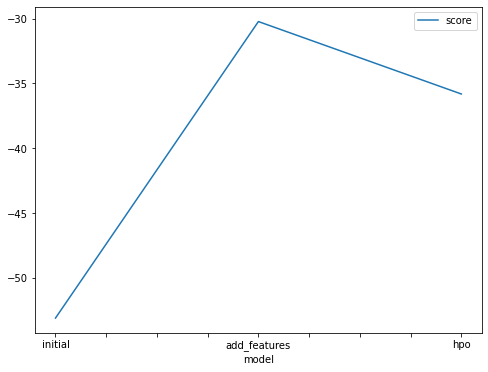

In [49]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-53.102, -30.224106, -35.8122]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')


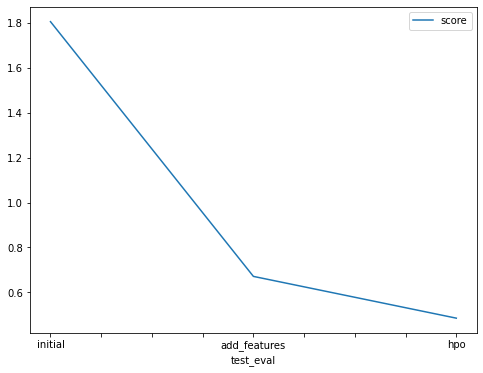

In [51]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80425, 0.67145, 0.48571]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [52]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ['default', 'default', 'GBM: num_leaves: lower=26, upper=66'],
    "hpo2": ['default', 'default', 'NN: dropout_prob: 0.0, 0.5'],
    "hpo3": ['default', 'default', 'GBM: num_boost_round: 100'],
    "score": [1.80425, 0.67145, 0.48571]
})

,model,hpo1,hpo2,hpo3,score
0,initial,default,default,default,1.80425
1,add_features,default,default,default,0.67145
2,hpo,"GBM: num_leaves: lower=26, upper=66","NN: dropout_prob: 0.0, 0.5",GBM: num_boost_round: 100,0.48571
